In [1]:
from PyPurityTools import PyPurityTools as ppt
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import savgol_filter
import matplotlib.style
import matplotlib as mpl
import math
import scipy.fftpack
from scipy.signal import butter,filtfilt

#Set default figure size
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams.update({'font.size': 22})

In [47]:
#Get some data
inputList,timeList=ppt.getScopeWaveforms("/Users/rjn/dune/data/pulserTest_03052022/width200ns_0_100mV.ch4.traces",False)
outputList,timeList=ppt.getScopeWaveforms("/Users/rjn/dune/data/pulserTest_03052022/width200ns_0_100mV.ch3.traces",False)
#inputList,timeList=ppt.getScopeWaveforms("/Users/rjn/dune/data/pulserTest_03052022/width1us_0_100mV.ch4.traces",False)
#outputList,timeList=ppt.getScopeWaveforms("/Users/rjn/dune/data/pulserTest_03052022/width1us_0_100mV.ch3.traces",False)
#inputList,timeList=ppt.getScopeWaveforms("/Users/rjn/dune/data/pulserTest_03052022/width100ns_0_300mV_ampScan.ch4.traces",False)
#outputList,timeList=ppt.getScopeWaveforms("/Users/rjn/dune/data/pulserTest_03052022/width100ns_0_300mV_ampScan.ch3.traces",False)

(1000, 5002) (1000, 5002) (5002,)


Text(0, 0.5, 'Voltage (Volts)')

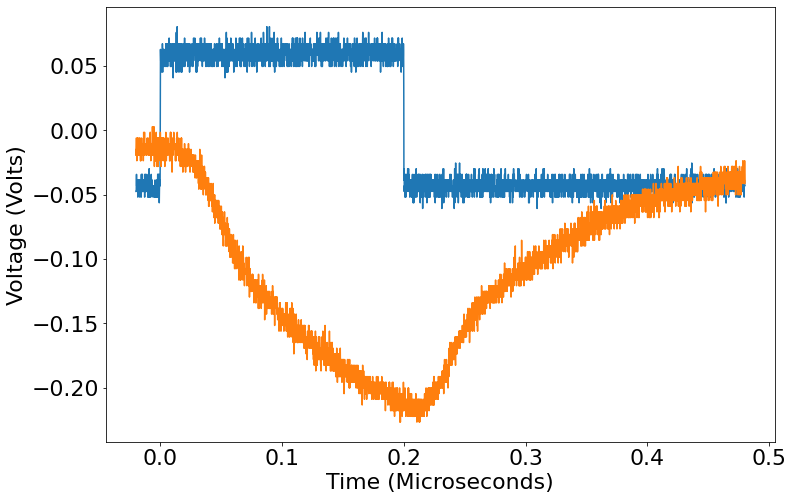

In [48]:
print(outputList.shape,inputList.shape,timeList.shape)

#Plot the first waveforms
fig, ax = plt.subplots()
ax.plot(timeList,inputList[0],label="Input Pulse")
ax.plot(timeList,outputList[0],label="Preamp Output")
ax.set_xlabel("Time (Microseconds)")
ax.set_ylabel("Voltage (Volts)")

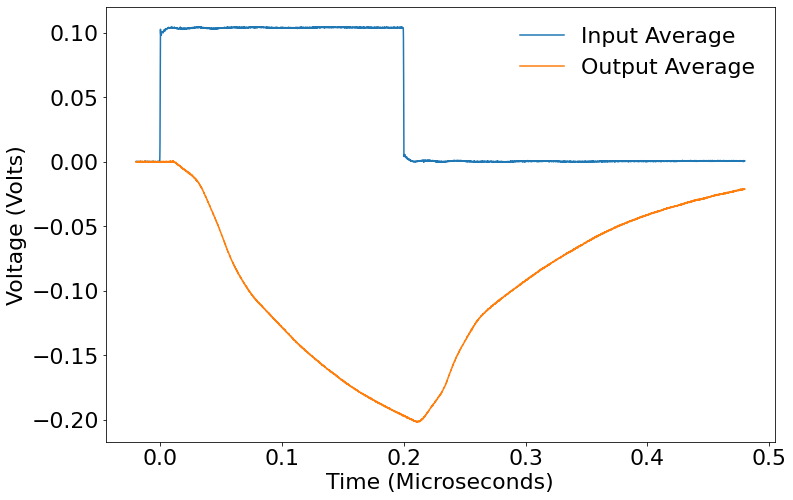

In [49]:
dt=timeList[1]-timeList[0]
fs=1./dt
inputAvg=np.mean(inputList,axis=0)
outputAvg=np.mean(outputList,axis=0)
inputAvg-=np.mean(inputAvg[0:100])
outputAvg-=np.mean(outputAvg[0:100])
#print(inputAvg.shape)

inputSmooth=ppt.butter_lowpass_filter(inputList[0],1000,fs,2)
outputSmooth=ppt.butter_lowpass_filter(outputList[0],1000,fs,2)

fig, ax = plt.subplots()
#ax.plot(timeList,inputSmooth,label="Input Smooth")
#ax.plot(timeList,outputSmooth,label="Output Smooth")
ax.plot(timeList,inputAvg,label="Input Average")
ax.plot(timeList,outputAvg,label="Output Average")
ax.set_xlabel("Time (Microseconds)")
ax.set_ylabel("Voltage (Volts)")
ax.legend()


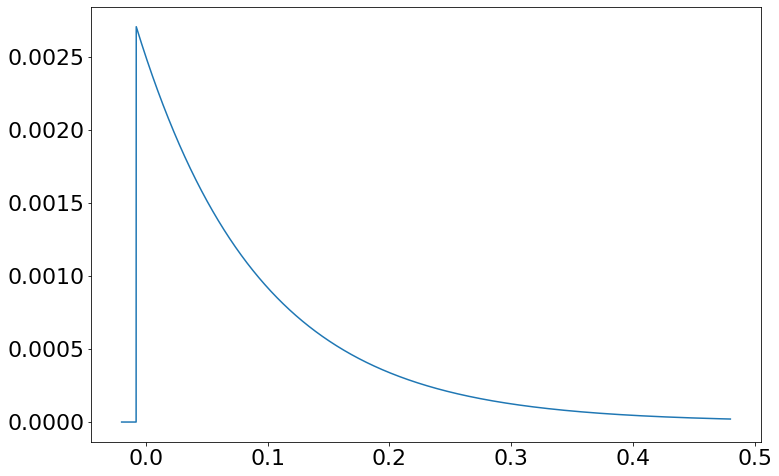

In [50]:
#Define a function which will operate on an array of x values all at once
#This function is zero until some offset and then exponential falls with a given time constant
def response(x,offset,tau,norm):
    conds = [x<0,(x>=0) & (x < offset), x>=offset]   #The two regions of x
    funcs = [lambda x: 0, lambda x:0, lambda x: norm*np.exp(-x/tau)]  #the lambda keyword is allowing us to define a quick function
    return np.piecewise(x, conds, funcs)  #Now do the piecewise calculation and return it


offset=timeList[120]
tau=0.1
norm=0.0025
fig, ax = plt.subplots()
ax.plot(timeList[0:10000],response(timeList[0:10000],offset,tau,norm),label="Response Function")



[-0.00802944  0.11682089 -0.00186949]


/Users/rjn/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


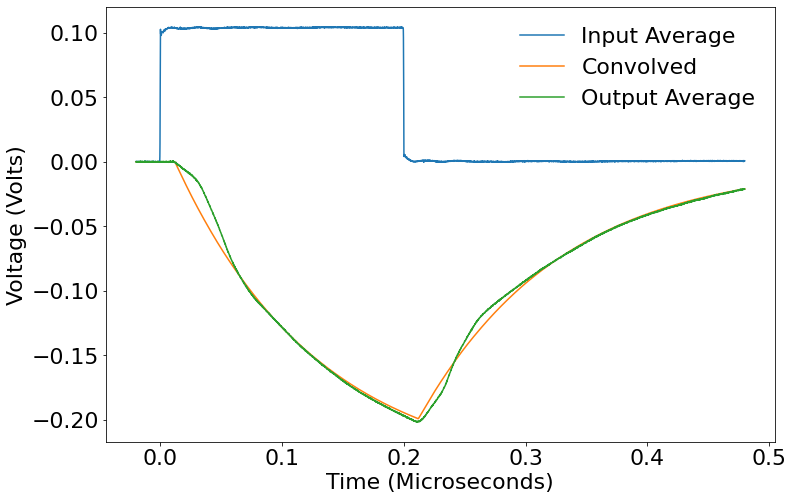

In [51]:
def func(xdata,offset,tau,norm):
    return signal.convolve(xdata, response(timeList[0:10000],offset,tau,norm), mode='full')[0:len(xdata)] 


from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, inputAvg, outputAvg,p0=[offset,tau,-1*norm])
print(popt)
fig, ax = plt.subplots()
ax.plot(timeList,inputAvg,label="Input Average")
#ax.plot(timeList,inputSmooth,label="2nd Order")
ax.plot(timeList,func(inputAvg,popt[0],popt[1],popt[2]),label="Convolved")
ax.plot(timeList,outputAvg,label="Output Average")
ax.set_xlabel("Time (Microseconds)")
ax.set_ylabel("Voltage (Volts)")
ax.legend()
#ax.set_xlim(-0.01,0.111)

